In [1]:
# !pip install pycryptodome==3.15.0
# !pip install PyPDF2

In [2]:
# !python -m pip install spacy
# !python -m spacy download pt

In [3]:
import nltk

In [4]:
import numpy as np

In [5]:
from nltk.util import ngrams

In [6]:
import pandas as pd

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
from sklearn import linear_model

In [10]:
import string

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [12]:
from unidecode import unidecode

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
import matplotlib.pyplot as plt

In [15]:
perguntas = [
    'Como esse COIL afetou sua consciência global?',
    'Que novas perspectivas você descobriu durante sua experiência no COIL?',
    'Que pontos em comum você notou durante sua experiência com o COIL?',
    'Você recomendaria uma experiência COIL a um amigo? Por que sim ou por que não?',
    'O que você diria que os alunos precisam fazer se quiserem ter uma experiência COIL bem-sucedida?',
    'Se você fosse fazer o COIL com colegas internacionais novamente, o que faria de diferente?',
    'O que tornou a experiência COIL única ou especial?',
    'O que você aprendeu sobre seus colegas internacionais? O que você aprendeu sobre si mesmo?',
    'De modo geral, qual foi o momento de aprendizado mais interessante e útil para você em suas atividades de colaboração com colegas internacionais?',
    'O que você aprendeu com o COIL que pode ajudá-lo em outras áreas de sua vida?',
    'O que você aprendeu com a apresentação dos seus colegas de equipe do Brasil no Padlet?',
    'Seus aprendizados do'
]

In [16]:
# print(f"Tamanho Perguntas: {len(perguntas)}   Respostas: {len(respostas)}")

In [17]:
# Carregar a base de dados de perguntas e respostas
df_respostas = pd.read_csv("../../../dados/pesquisa-sol/reflexoes-coil.csv", encoding='utf8', delimiter=";", quotechar='"', 
    names=['id', 'hora_inicio', 'hora_conclusao', 'email', 'nome', 'ult_mod', 'nome_entrevistado', 'q1', 'q2', 'q3', 'q4', 
           'q5', 'q6', 'q7', 'q8', 'q9', 'q10'], header=1)
df_respostas.describe()

,id,ult_mod
count,14.0000,0.0
mean,8.5000,NaN
std,4.1833,NaN
min,2.0000,NaN
25%,5.2500,NaN
50%,8.5000,NaN
75%,11.7500,NaN
max,15.0000,NaN


In [18]:
# Remover colunas inúteis da base de respostas
df_respostas.drop(
    columns = ['hora_inicio', 'hora_conclusao', 'email', 'nome', 'ult_mod'],
    inplace = True
)

In [19]:
# Remover linhas com conteudo N/A
df_respostas.dropna(inplace = True)

In [20]:
# Carregar a base de dados para treino
df = pd.read_csv("../../../dados/imdb-reviews-pt-br.csv")
df.describe()

,id
count,49459.000000
mean,24730.960917
std,14277.792868
min,1.000000
25%,12366.500000
50%,24731.000000
75%,37095.500000
max,49460.000000


## Preparo do data set

In [21]:
# Remover colunas inúteis
df.drop(
    columns = ["text_en"],
    inplace = True
)

In [22]:
# Remover linhas com conteudo N/A
df.dropna(inplace = True)

### Criar a coluna numerica para representar o 'pos' e 'neg'

In [23]:
df = df.assign(sentiment_value = [1 if i == 'pos' else 0  for i in df["sentiment"]])

In [24]:
df

,id,text_pt,sentiment,sentiment_value
0,1,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Filmes de fotos de latão não é uma palavra apr...,neg,0
...,...,...,...,...
49454,49456,"Como a média de votos era muito baixa, e o fat...",pos,1
49455,49457,O enredo teve algumas reviravoltas infelizes e...,pos,1
49456,49458,Estou espantado com a forma como este filme e ...,pos,1
49457,49459,A Christmas Together realmente veio antes do m...,pos,1


### Preparo do texto text_pt

#### Funções para o tratamento de texto

In [25]:
# Função para preparar as palavras do texto
def preparar_texto( texto ):
    # Converter em minusculo
    texto_limpo = texto.lower()
    # Remover pontuação e caracteres especiais
    translator = str.maketrans('\n\r\t', '   ', string.punctuation)
    texto_limpo = texto_limpo.translate(translator)
    # Remover os acentos
    texto_limpo = unidecode(texto_limpo)
    return texto_limpo

In [26]:
# Remover Stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
def remove_stopwords( texto ):
    tokens = []
    for token in nltk.tokenize.word_tokenize(texto, language='portuguese'):
        if token not in stopwords:
            tokens.append(token)
    return " ".join(tokens)

In [27]:
len(stopwords)

207

In [28]:
# Lematização
def lematizar( texto ): 
    doc = nlp(texto)
    doc_lemma = [token.lemma_ for token in doc if token.pos_ == 'NOUN']
    return " ".join(doc_lemma)

In [29]:
# Stemming
stemmer = nltk.RSLPStemmer()
def stemmer_text( texto ):
    if isinstance(texto, str):
        lista_palavras = texto.split(" ")
        nova_lista = []
        for palavra in lista_palavras:
            stemmed = stemmer.stem( palavra )
            nova_lista.append(stemmed)
        return " ".join(nova_lista)
    else:
        return texto

In [30]:
def transformar_texto( texto ):
    texto_limpo = preparar_texto( texto )
    return texto_limpo
    # texto_sem_stopwords = remove_stopwords(texto_limpo)
    # texto_stemmed = stemmer_text(texto_sem_stopwords)
    # return texto_stemmed

#### Prepara o texto e coloca em uma variavel separada

In [31]:
count = 0
def invocar_transformar_texto( texto ):
    global count
    count += 1
    if count % 1000 == 0:
        print(f"Analisando linha: {count}")
    return transformar_texto( texto )

texto_preparado = df["text_pt"].apply(invocar_transformar_texto)

Analisando linha: 1000
Analisando linha: 2000
Analisando linha: 3000
Analisando linha: 4000
Analisando linha: 5000
Analisando linha: 6000
Analisando linha: 7000
Analisando linha: 8000
Analisando linha: 9000
Analisando linha: 10000
Analisando linha: 11000
Analisando linha: 12000
Analisando linha: 13000
Analisando linha: 14000
Analisando linha: 15000
Analisando linha: 16000
Analisando linha: 17000
Analisando linha: 18000
Analisando linha: 19000
Analisando linha: 20000
Analisando linha: 21000
Analisando linha: 22000
Analisando linha: 23000
Analisando linha: 24000
Analisando linha: 25000
Analisando linha: 26000
Analisando linha: 27000
Analisando linha: 28000
Analisando linha: 29000
Analisando linha: 30000
Analisando linha: 31000
Analisando linha: 32000
Analisando linha: 33000
Analisando linha: 34000
Analisando linha: 35000
Analisando linha: 36000
Analisando linha: 37000
Analisando linha: 38000
Analisando linha: 39000
Analisando linha: 40000
Analisando linha: 41000
Analisando linha: 42000
A

### Criar o dicionario e o Bag of Words

In [32]:
# # Criar o bag_of_words com base no CountVectorizer
# vetorizador = CountVectorizer(max_features=100, lowercase=False)
# bag_of_words = vetorizador.fit_transform(texto_preparado)
# bag_of_words.shape    # Verifica o formato da Matriz

In [33]:
# # Criar o bag_of_words com base no TfidfVectorizer usando NGram 3
# vetorizador = TfidfVectorizer(lowercase=False, max_features=100, ngram_range=(1, 3))
# bag_of_words = vetorizador.fit_transform(texto_preparado)
# bag_of_words.shape

In [34]:
# Criar o bag_of_words com base no TfidfVectorizer
vetorizador = TfidfVectorizer(lowercase=False, max_features=2000)
bag_of_words = vetorizador.fit_transform(texto_preparado)
bag_of_words.shape

(49459, 2000)

In [35]:
dicionario = vetorizador.get_feature_names_out()

In [36]:
bow = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=dicionario)

In [37]:
train, test, train_class, test_class = train_test_split(bow, 
                                                        df["sentiment_value"], 
                                                        random_state = 100)

In [48]:
reg_logistica = LogisticRegression()
reg_logistica.fit(train, train_class)
acuracia = reg_logistica.score(test, test_class)

In [49]:
acuracia

0.874646178730287

# Acuracias
#### Sem tratamento do texto ==> 0.7013344116457744
#### Colocando as palavras em minusculo ==> 0.7107966033158107
#### Remover os caracteres especiais ==> 0.7273756570966438
#### Remover os acentos ==> 0.7272139102304893
#### Remover as stopwords ==> 0.7199353012535382
#### Remover stopwords e aplicar raiz do texto (stemm) ==> 0.7532551556813587
#### Aplicando o TF_ID ao inves da contagem de palavras ==> 0.7553578649413668
#### Aplicando NGRAM (1,3) ==> 0.7553578649413668
#### Aplicando TF_ID e MAX_Features = 200 ==> 0.7955519611807521
#### Aplicando TF_ID e MAX_Features = 300 ==> 0.8188435099069955 
#### Aplicando TF_ID e MAX_Features = 500 ==> 0.8418924383340073
#### Aplicando TF_ID e MAX_Features = 1000 ==> 0.8639708855640922
#### Aplicando TF_ID e MAX_Features = 2000 ==> 0.8760210270926001


In [41]:
# Tratar as respostas
respostas_preparadas = np.array([invocar_transformar_texto(r) for r in df_respostas['q1']])

In [43]:
vetorizador = TfidfVectorizer(lowercase=False, max_features=2000, vocabulary=dicionario)
bag_of_words_respostas = vetorizador.fit_transform(respostas_preparadas)
bag_of_words_respostas.shape

(13, 2000)

In [62]:
reg_logistica.predict_proba(bag_of_words_respostas)

array([[0.06796662, 0.93203338],
       [0.08197313, 0.91802687],
       [0.15435928, 0.84564072],
       [0.20621124, 0.79378876],
       [0.09202709, 0.90797291],
       [0.28476159, 0.71523841],
       [0.25508917, 0.74491083],
       [0.16008031, 0.83991969],
       [0.27746938, 0.72253062],
       [0.0972645 , 0.9027355 ],
       [0.16169132, 0.83830868],
       [0.14678505, 0.85321495],
       [0.07616359, 0.92383641]])

In [61]:
np.max(reg_logistica.predict_proba(bag_of_words_respostas), axis=1)

array([0.93203338, 0.91802687, 0.84564072, 0.79378876, 0.90797291,
       0.71523841, 0.74491083, 0.83991969, 0.72253062, 0.9027355 ,
       0.83830868, 0.85321495, 0.92383641])

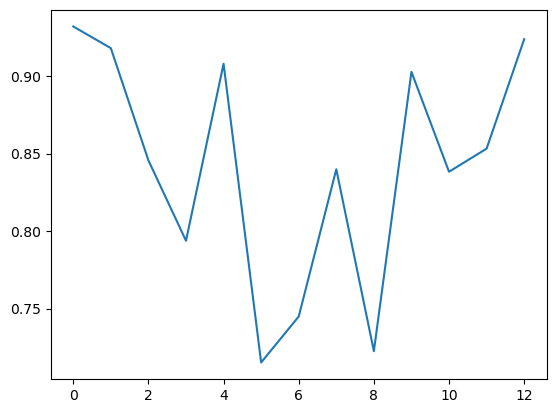

In [60]:
plt.plot(reg_logistica.predict_proba(bag_of_words_respostas)[:, 1])

In [77]:
texto = "tive a experiência mais horrível da minha excelente vida"

In [78]:
bow = vetorizador.fit_transform([texto])

In [79]:
reg_logistica.predict(bow)

array([1], dtype=int64)

In [ ]:
# i = 0
# print("Linhas size: ", len(linhas))
# while i < len(linhas):
#     linha = linhas[i].lower()
#     linha_tokens = nltk.tokenize.word_tokenize(linha, language='portuguese')
#     linha_tokens_limpos = remove_stop_words(linha_tokens)
#     i += 1
#     if linha_tokens_limpos is None or len(linha_tokens_limpos) < 3:
#         continue
#     linha_ngrams = ngrams(linha_tokens_limpos, 3)
#     linha_points = 0
#     for pergunta in perguntas:
#         pergunta_tokens = nltk.tokenize.word_tokenize(pergunta, language='portuguese')
#         pergunta_no_stopwords = remove_stop_words(pergunta_tokens)
#         for ngram_tuple in linha_ngrams: 
#             ngram_tupla_texto = " ".join(ngram_tuple)
#             if ngram_tupla_texto in pergunta.lower():
#                 linha_points += 1
# #                 print("Pontos: ", linha_points)
# #                 print("Pergunta: ", pergunta)
# #                 print("Linha: ", linha)
# #                 print("NGram_Tupla: ", ngram_tupla_texto)
#         if linha_points > 3: 
#             print("Linha: ", linha)
#             print("Corresponde a pergunta: ", pergunta.lower())

    